In [4]:
import sdf_helper as sh
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fftpack import fft

base_path = '/media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch-set2/epoch2d/激光电子对撞/激光5GeV+bx1e8T'
# file_prefix = "field_FFT"
file_prefix = "field_FFT"
file_suffix = ".sdf"

# file_index = 5
# file_name = f"{file_prefix}{file_index:04d}{file_suffix}"
# file_path = os.path.join(base_path, file_name)
# Field_Data = sh.getdata(file_path)
# sh.list_variables(Field_Data)

start_index = 0
end_index = 8000  # 共2001帧
dt_fs = 0.02       # 时间间隔 0.01 fs
dt = dt_fs * 1e-15  # 转为秒

# === 准备电场序列容器 ===
ey, ex, ez = [], [], []

# === 读取数据 ===
def read_field_generator(base_path, file_prefix, file_suffix, start_index, end_index):
    for file_index in range(start_index, end_index + 1):
        file_name = f"{file_prefix}{file_index:04d}{file_suffix}"
        file_path = os.path.join(base_path, file_name)
        Field_Data = sh.getdata(file_path)
        ex_val = Field_Data.Electric_Field_Ex_Core_TT.data[750, 300]
        ey_val = Field_Data.Electric_Field_Ey_Core_TT.data[750, 300]
        ez_val = Field_Data.Electric_Field_Ez_Core_TT.data[750, 300]
        yield ex_val, ey_val, ez_val

# === 填充电场序列 ===
for ex_val, ey_val, ez_val in read_field_generator(base_path, file_prefix, file_suffix, start_index, end_index):
    ex.append(ex_val)
    ey.append(ey_val)
    ez.append(ez_val)

# === 转为 NumPy 数组 ===
ex_array = np.array(ex)
ey_array = np.array(ey)
ez_array = np.array(ez)

Reading file /media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch-set2/epoch2d/激光电子对撞/激光5GeV+bx1e8T/field_FFT0000.sdf
t() = time
x(3001, 1501) = grid
y(3001, 1501) = grid
xc(3000, 1500) = grid_mid
yc(3000, 1500) = grid_mid
Reading file /media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch-set2/epoch2d/激光电子对撞/激光5GeV+bx1e8T/field_FFT0001.sdf
t() = time
x(3001, 1501) = grid
y(3001, 1501) = grid
xc(3000, 1500) = grid_mid
yc(3000, 1500) = grid_mid
Reading file /media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch-set2/epoch2d/激光电子对撞/激光5GeV+bx1e8T/field_FFT0002.sdf
t() = time
x(3001, 1501) = grid
y(3001, 1501) = grid
xc(3000, 1500) = grid_mid
yc(3000, 1500) = grid_mid
Reading file /media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch-set2/epoch2d/激光电子对撞/激光5GeV+bx1e8T/field_FFT0003.sdf
t() = time
x(3001, 1501) = grid
y(3001, 1501) = grid
xc(3000, 1500) = grid_mid
yc(3000, 1500) = grid_mid
Reading file /media/lan/4248e56e-6d9a-4026-afad-e8b1d59ceab0/epoch-set2/epoch2d/激光电子对撞/激光5GeV+bx1e8T/fie

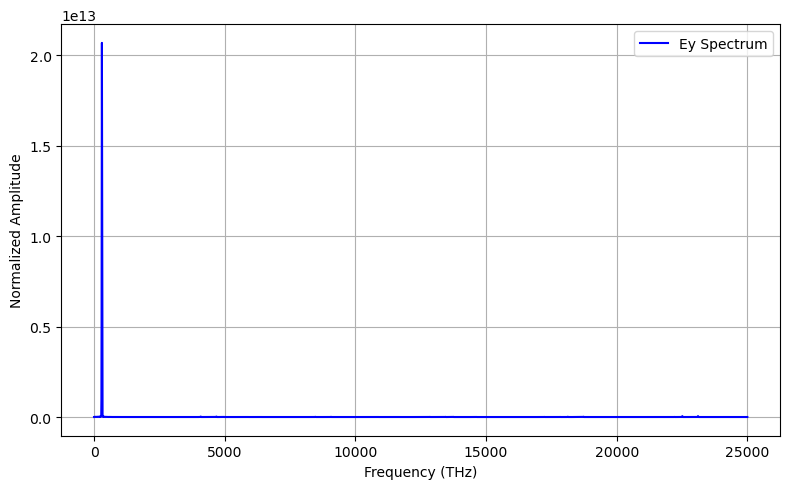

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# === 基本参数 ===
dt = dt_fs * 1e-15        # 时间间隔（单位：秒），dt_fs 为飞秒
N = len(ey_array)         # 采样点数
freqs = fftfreq(N, d=dt)  # 频率坐标

# === 傅里叶变换（Ey 和 Ez）===
fft_ex = fft(ex_array)
fft_ey = fft(ey_array)
fft_ez = fft(ez_array)

# === 只保留正频率部分，并归一化 ===
mask = freqs >= 0
freqs_thz = freqs[mask] * 1e-12          # 转为 THz
fft_ey_plus = fft_ey[mask] / N
fft_ez_plus = fft_ez[mask] / N
fft_ex_plus = fft_ex[mask] / N

# === Ey 频谱（幅度）===
spectrum_ey = np.abs(fft_ey_plus)
spectrum_ey[1:-1] *= 2  # 除直流和 Nyquist 外，乘以2补能量

# === Ez 频谱（幅度）===
spectrum_ez = np.abs(fft_ez_plus)
spectrum_ez[1:-1] *= 2  # 除直流和 Nyquist 外，乘以2补能量

# === Ez 频谱（幅度）===
spectrum_ex = np.abs(fft_ex_plus)
spectrum_ex[1:-1] *= 2  # 除直流和 Nyquist 外，乘以2补能量


# === 绘制 Ey 频谱 ===
plt.figure(figsize=(8, 5))
plt.plot(freqs_thz, spectrum_ey, label="Ey Spectrum", color="blue")
plt.xlabel("Frequency (THz)")
plt.ylabel("Normalized Amplitude")
# plt.xlim(0, 1000)  # 可根据需要调整频率范围
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# === 斯托克斯参数计算 ===
s0 = np.abs(fft_ey_plus)**2 + np.abs(fft_ez_plus)**2
s1 = np.abs(fft_ey_plus)**2 - np.abs(fft_ez_plus)**2
s2 = 2 * np.real(fft_ey_plus * np.conj(fft_ez_plus))
s3 = 2 * np.imag(fft_ey_plus * np.conj(fft_ez_plus))

# === 频谱总积分（可视为全频带功率）===
S0 = np.sum(s0)
S1 = np.sum(s1)
S2 = np.sum(s2)
S3 = np.sum(s3)

# === 偏振度计算 ===
P = np.sqrt(S1**2 + S2**2 + S3**2) / S0       # 总偏振度
P_lin = np.sqrt(S1**2 + S2**2) / S0           # 线偏振度
P_circ = S3 / S0                              # 圆偏振度

# === 输出结果 ===
print("=== 偏振度分析结果 ===")
print(f"总偏振度     P      = {P:.4f}")
print(f"线偏振度     P_lin  = {P_lin:.4f}")
print(f"圆偏振度     P_circ = {P_circ:.4f}")

=== 偏振度分析结果 ===
总偏振度     P      = 0.9995
线偏振度     P_lin  = 0.9995
圆偏振度     P_circ = -0.0003


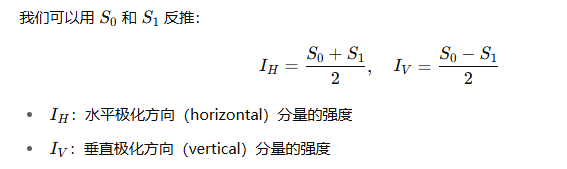

In [12]:
# === 水平极化和垂直极化总强度 ===
I_H = np.sum(np.abs(fft_ey_plus)**2)   # 水平极化（Y方向）
I_V = np.sum(np.abs(fft_ez_plus)**2)   # 垂直极化（Z方向）

# === 输出极化分量强度（可选归一化）===
print(f"水平极化分量强度 I_H = {I_H:.4f}  ({I_H / S0:.4%} of total)")
print(f"垂直极化分量强度 I_V = {I_V:.4f}  ({I_V / S0:.4%} of total)")


水平极化分量强度 I_H = 62641453525502895377612800.0000  (99.9763% of total)
垂直极化分量强度 I_V = 14861432913959527120896.0000  (0.0237% of total)


In [3]:
33.7598-33.7816
0.02179999999999893e-6/3e8

7.26666666666631e-17

In [5]:
34.57081-34.55619
0.014620000000000744e-6/3e8

4.8733333333335813e-17